In [36]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec  # for unequal plot boxes
import ROOT as R

%matplotlib inline

import lax 
from lax.lichens import sciencerun1
from lax.lichens import sciencerun0
from pax import units
import hax
hax.init(experiment='XENON1T',
         pax_version_policy = 'v6.10.1',
         main_data_paths= ['/dali/lgrandi/xenon1t/processed/pax_v6.10.1/'], 
         minitree_paths = ['/home/gvolta/Desktop/minitrees',
                           '/dali/lgrandi/xenon1t/minitrees/pax_v6.10.1/'],
         make_minitrees = False)

%run '/home/gvolta/Desktop/Function/Useful/Def.ipynb'
%run '/home/gvolta/Desktop/Function/Field_Correction/Field_Correction.ipynb'

In [30]:
 %lsmagic

Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%perl  %%prun  %%pypy  %%python  %%python2  %%python3

## Selection of dataset

In [2]:
datasets = hax.runs.datasets
datasets = hax.runs.tags_selection(datasets, include=['cathode_-5kV', 'cathode_-5kv'],
                                   exclude= ['bad','bad,waterfilling','waterfilling, bad','flash','messy','noise',
                                   'afterpulse','hiccup','Flash','Hiccup'])

dataset_select = datasets[((datasets['source__type']==('neutron_generator'))| 
                           (datasets['source__type']==('rn220'))|(datasets['source__type']==('Rn220')))]

print(len(datasets),'-> Select Neutron Generator runs->',len(dataset_select),'(%.6f%%)'
      %(len(dataset_select)/len(datasets)*100))

dataset_select['duration'] = dataset_select['end'].sub(dataset_select['start'])

b = len(dataset_select)
dataset_select = dataset_select[dataset_select['duration'] > '00:50:00']
print(b,'-> Get only ~1h runs ->',len(dataset_select),'(%.2f%%)'%(len(dataset_select)/b*100))
name = ['181009_2042', '181013_0424']
dataset_select = dataset_select[~dataset_select['name'].isin(name)]
print('After removing the bad run, we got a total of %.3f days of NG+Rn220 data to play with!' 
      %(np.sum(dataset_select['duration'])/np.timedelta64(1, 'D')))
b = len(dataset_select)
dataset_select = dataset_select[(dataset_select['end'] > pd.to_datetime('20181001', 
                                                                        format='%Y%m%d', errors='ignore'))&
                                (dataset_select['end'] < pd.to_datetime('20181031', 
                                                                        format='%Y%m%d', errors='ignore'))
                                ]
print('Total NG+Rn220 datasets: %d'%(b))
print('Lenght NG: ',len(dataset_select[dataset_select['source__type'] == 'neutron_generator']))
print('Lenght Rn: ',len(dataset_select[(datasets['source__type']==('rn220'))|(datasets['source__type']==('Rn220'))]))
runNG_start = 22820
runNG_end = 22864
runRn_start = 22879
runRn_end = 22997
NG = dataset_select[(dataset_select['number'] >= 22820) & (dataset_select['number'] <= 22864)]
Rn = dataset_select[(dataset_select['number'] >= 22879) & (dataset_select['number'] <= 22997)]
#print('Lenght NG: ', len(NG), '\tLenght Rn: ', len(Rn))
bad_runnbr = [22823,22832,22843,22844,22845,22849,22851,22853,22854,22855,22863,22836,22839, #NG datasets (13)
              22888,22897,22906,22909,22911,22912,22913,22914,22943,22944,22945,22951,23020, #Rn220 datasets (13)
             ]
#bad_runnbr = [17543,17960,17928,17890,17897,17901,17902,17871]

184 -> Select Neutron Generator runs-> 137 (74.456522%)
137 -> Get only ~1h runs -> 131 (95.62%)
After removing the bad run, we got a total of 5.379 days of NG+Rn220 data to play with!
Total NG+Rn220 datasets: 129
Lenght NG:  41
Lenght Rn:  88


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [3]:
dataNG = hax.minitrees.load(NG.name, 
                            ['Fundamentals', 'Basics', 'Extended', 'Corrections'],
                            cache_file = '/home/gvolta/Desktop/minitrees/NG_post_SR1.haxcache',   
                            force_reload=False, num_workers=10)
print('\n', dataNG.columns.values)


 ['alt_s1_interaction_drift_time' 'alt_s1_interaction_z'
 'alt_s2_interaction_s2_range_50p_area'
 'alt_s2_interaction_s2_range_80p_area' 'alt_s2_interaction_x'
 'alt_s2_interaction_y' 'alt_s2_interaction_z' 'cs1' 'cs1_no_field_corr'
 'cs1_tpf_2dfdc' 'cs2' 'cs2_alpha' 'cs2_bottom' 'cs2_bottom_alpha'
 'cs2_top' 'cs2_top_alpha' 'drift_time' 'event_duration' 'event_number'
 'event_time' 'largest_coincidence' 'largest_other_s1' 'largest_other_s2'
 'largest_other_s2_delay_main_s1' 'largest_other_s2_delay_main_s2'
 'largest_other_s2_pattern_fit' 'largest_s2_before_main_s2_area'
 'largest_unknown' 'largest_veto' 'r' 'r_3d_nn' 'r_3d_tpf'
 'r_correction_2d' 'r_correction_3d_nn' 'r_correction_3d_tpf' 'r_observed'
 'r_observed_nn' 'r_observed_tpf' 'r_pos_correction' 'run_number' 's1'
 's1_area_fraction_top' 's1_area_fraction_top_probability'
 's1_largest_hit_area' 's1_largest_hit_channel'
 's1_n_contributing_channels' 's1_pattern_fit' 's1_range_100p_area'
 's1_range_50p_area' 's1_range_80p_area' 

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/minitrees.py:611: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  result.cut_history = store.get_storer('data').attrs.cut_history


In [4]:
dataRn = hax.minitrees.load(Rn.name, 
                            ['Fundamentals', 'Basics', 'Extended', 'Corrections'],
                            cache_file = '/home/gvolta/Desktop/minitrees/Rn_post_SR1.haxcache',   
                            force_reload=False, num_workers=10)
print('\n', dataRn.columns.values)


 ['alt_s1_interaction_drift_time' 'alt_s1_interaction_z'
 'alt_s2_interaction_s2_range_50p_area'
 'alt_s2_interaction_s2_range_80p_area' 'alt_s2_interaction_x'
 'alt_s2_interaction_y' 'alt_s2_interaction_z' 'cs1' 'cs1_no_field_corr'
 'cs1_tpf_2dfdc' 'cs2' 'cs2_alpha' 'cs2_bottom' 'cs2_bottom_alpha'
 'cs2_top' 'cs2_top_alpha' 'drift_time' 'event_duration' 'event_number'
 'event_time' 'largest_coincidence' 'largest_other_s1' 'largest_other_s2'
 'largest_other_s2_delay_main_s1' 'largest_other_s2_delay_main_s2'
 'largest_other_s2_pattern_fit' 'largest_s2_before_main_s2_area'
 'largest_unknown' 'largest_veto' 'r' 'r_3d_nn' 'r_3d_tpf'
 'r_correction_2d' 'r_correction_3d_nn' 'r_correction_3d_tpf' 'r_observed'
 'r_observed_nn' 'r_observed_tpf' 'r_pos_correction' 'run_number' 's1'
 's1_area_fraction_top' 's1_area_fraction_top_probability'
 's1_largest_hit_area' 's1_largest_hit_channel'
 's1_n_contributing_channels' 's1_pattern_fit' 's1_range_100p_area'
 's1_range_50p_area' 's1_range_80p_area' 

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/minitrees.py:611: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  result.cut_history = store.get_storer('data').attrs.cut_history


### S2 correction

In [5]:
# First cut: TPC volume and S2SingleScatter (https://github.com/XENON1T/lax/blob/master/lax/lichens/sciencerun0.py)
dataNG_nocuts = dataNG
dataNG = dataNG.dropna(subset=['x_observed_nn', 'y_observed_nn', 'z_observed'])
print('After dropna: ', len(dataNG_nocuts), ' -> ', len(dataNG))
dataNG = hax.cuts.selection(dataNG, (dataNG['z_observed'] > -96.6) & (dataNG['z_observed'] < 0))
dataNG = hax.cuts.selection(dataNG, (dataNG['cs1'] > 0) & (dataNG['cs1'] < 200) & (dataNG['cs2'] > 0))
dataNG = sciencerun0.S2SingleScatter().process(dataNG)

After dropna:  3122343  ->  2937157
Unnamed selection: 440900 rows removed (84.99% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


Unnamed selection: 2317825 rows removed (7.15% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/lax-1.6.0-py3.4.egg/lax/lichens/sciencerun0.py:728: RuntimeWarning: overflow encountered in exp
  another_term_0 = 1 / (np.exp((s2_area - 23300) * 5.91e-4) + 1)


In [6]:
# First cut: TPC volume and S2SingleScatter (https://github.com/XENON1T/lax/blob/master/lax/lichens/sciencerun0.py)
dataRn_nocuts = dataRn
dataRn = dataRn.dropna(subset=['x_observed_nn', 'y_observed_nn', 'z_observed'])
print('After dropna: ', len(dataRn_nocuts), ' -> ', len(dataRn))
dataRn = hax.cuts.selection(dataRn, (dataRn['z_observed'] > -96.6) & (dataRn['z_observed'] < 0))
dataRn = hax.cuts.selection(dataRn, (dataRn['cs1'] > 0) & (dataRn['cs1'] < 200) & (dataRn['cs2'] > 0))
dataRn = sciencerun0.S2SingleScatter().process(dataRn)

After dropna:  9790250  ->  3645255
Unnamed selection: 1043860 rows removed (71.36% passed)
Unnamed selection: 2497687 rows removed (3.99% passed)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/lax-1.6.0-py3.4.egg/lax/lichens/sciencerun0.py:728: RuntimeWarning: overflow encountered in exp
  another_term_0 = 1 / (np.exp((s2_area - 23300) * 5.91e-4) + 1)


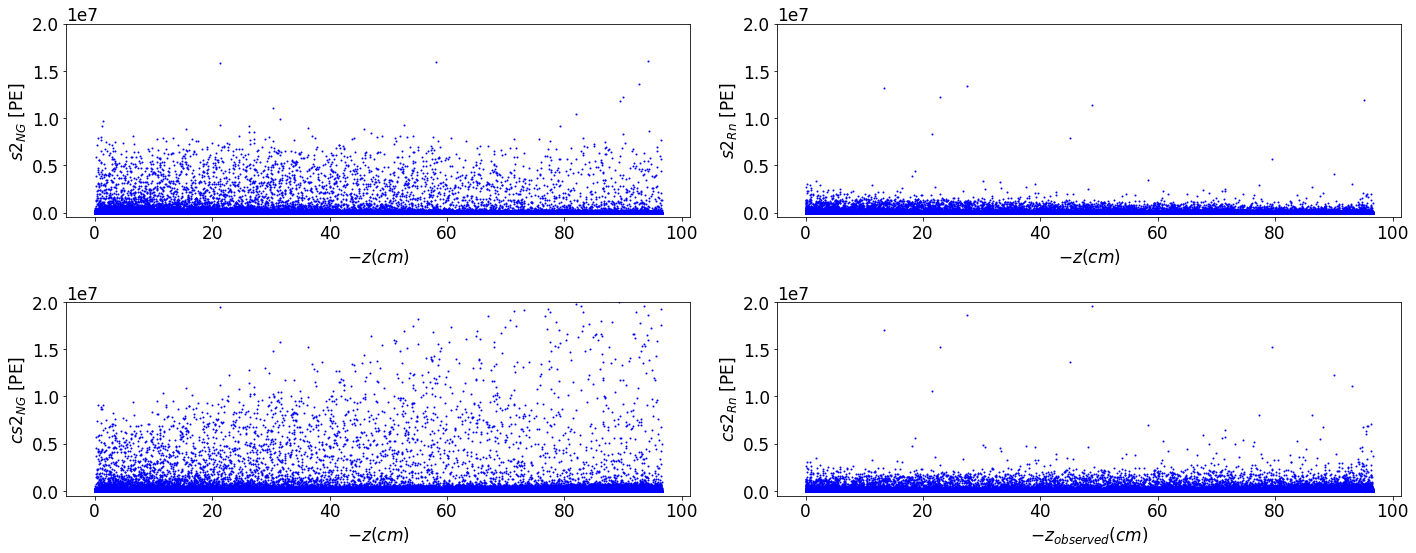

In [7]:
plt.figure(1, figsize=(20,8))
plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams.update({'font.size':17})

plt.subplot(221)
plt.plot(-dataNG['z_observed'], dataNG['s2'],
         linestyle='', marker='o', markersize=1, color='blue')
plt.ylim(-0.05*10**7,2*10**7)
plt.xlabel('$-z (cm)$')
plt.ylabel('$s2_{NG}$ [PE]')

plt.subplot(222)
plt.plot(-dataRn['z_observed'], dataRn['s2'],
         linestyle='', marker='o', markersize=1, color='blue')
plt.ylim(-0.05*10**7,2*10**7)
plt.xlabel('$-z (cm)$')
plt.ylabel('$s2_{Rn}$ [PE]')

plt.subplot(223)
plt.plot(-dataNG['z_observed'], dataNG['cs2'],
         linestyle='', marker='o', markersize=1, color='blue')
plt.ylim(-0.05*10**7,2*10**7)
plt.xlabel('$-z (cm)$')
plt.ylabel('$cs2_{NG}$ [PE]')

plt.subplot(224)
plt.plot(-dataRn['z_observed'], dataRn['cs2'],
         linestyle='', marker='o', markersize=1, color='blue')
plt.ylim(-0.05*10**7,2*10**7)
plt.xlabel('$-z_{observed} (cm)$')
plt.ylabel('$cs2_{Rn}$ [PE]')

plt.tight_layout()

In [8]:
def xi(cS2, S2, t, tau):
    xi = (cS2/S2)*np.exp(-t/tau)
    xi = 1
    return xi
def Elf_correction(S2, t, tau):
    xi = 1
    #dataNG['xi'] = xi(dataNG['cs2_a_bottom'], dataNG['s2_a_bottom'], dataNG['int_a_drift_time']/1000, tau)
    return S2 * xi * np.exp(t/tau)

###### Electron lifetime post-SR1 #####
tau = 834.305532209 #us
#######################################
dataNG['cs2_new'] = Elf_correction(dataNG['s2'], dataNG['drift_time']/1000, tau)
dataRn['cs2_new'] = Elf_correction(dataRn['s2'], dataRn['drift_time']/1000, tau)

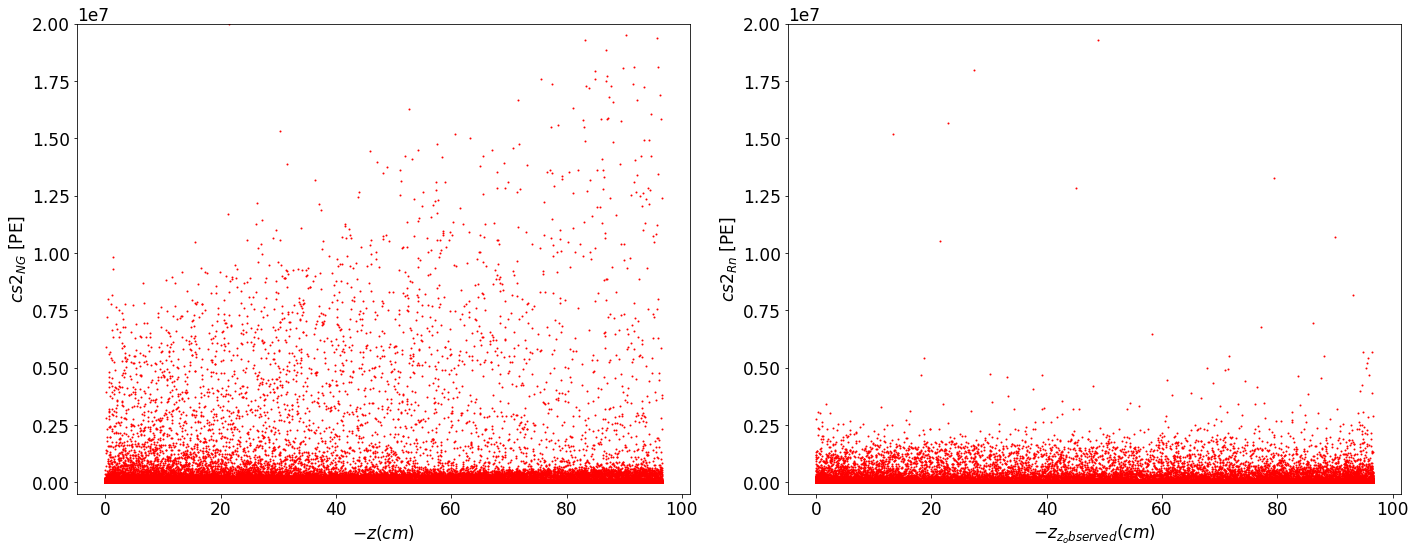

In [9]:
plt.figure(1, figsize=(20,8))
plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams.update({'font.size':17})

plt.subplot(121)
plt.plot(-dataNG['z_observed'], dataNG['cs2_new'],
         linestyle='', marker='o', markersize=1, color='red')
plt.ylim(-0.05*10**7,2*10**7)
plt.xlabel('$-z (cm)$')
plt.ylabel('$cs2_{NG}$ [PE]')

plt.subplot(122)
plt.plot(-dataRn['z_observed'], dataRn['cs2_new'],
         linestyle='', marker='o', markersize=1, color='red')
plt.ylim(-0.05*10**7,2*10**7)
plt.xlabel('$-z_{observed} (cm)$')
plt.ylabel('$cs2_{Rn}$ [PE]')

plt.tight_layout()

### Neutron Generator

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


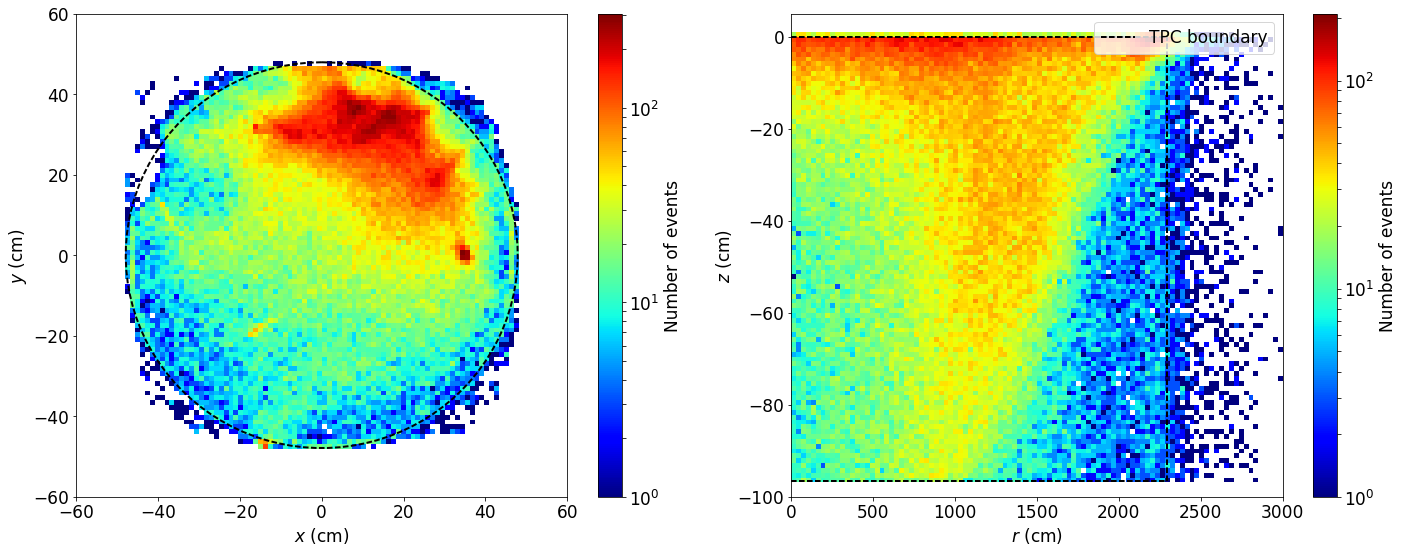

In [10]:
plt.figure(1, figsize=(20,8))
plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams.update({'font.size':17})

plt.subplot(121)
plt.hist2d(dataNG['x_observed_nn'], dataNG['y_observed_nn'], bins=(100,100), 
           range=((-60,60), (-60,60)), 
           cmap=plt.cm.jet, norm=matplotlib.colors.LogNorm(),
           cmin = 1,alpha = 1)
plt_circle(linewidth=2, color='black', linestyle='--')
plt.colorbar(label='Number of events')
plt.xlabel('$x~observed_{nn}$ (cm)')
plt.ylabel('$y~observed_{nn}$ (cm)')

plt.subplot(122)
plt.hist2d((dataNG['r_observed_nn']**2), dataNG['z_observed'], bins=(100,100), 
           range=((0,3000), (-100,5)), 
           cmap=plt.cm.jet, norm=matplotlib.colors.LogNorm(),
           cmin = 1,alpha = 1)
TPC_limit(1, linewidth=2, color='black', linestyle='--')
plt.colorbar(label='Number of events')
plt.xlabel('$r~observed_{nn}$ (cm)')
plt.ylabel('$z~observed$ (cm)')

plt.tight_layout()

AttributeError: 'TH2F' object has no attribute 'x'

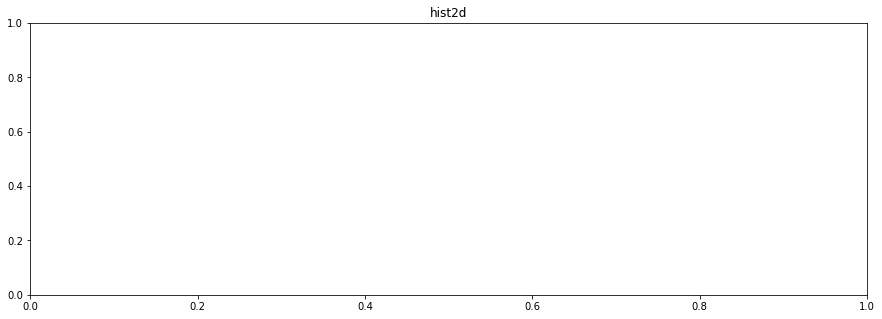

In [62]:
import ROOT as R
from rootpy.plotting import root2matplotlib as rplt
c1 = R.TCanvas( 'c1', 'c1', 200, 10, 700, 500 )
h1 = R.TH2F("h1","test",100,0,1000,1000,0,1000)
for i in range(len(dataNG['cs1'])):
    h1.Fill(dataNG['cs1'].iloc[i], dataNG['cs2_bottom'].iloc[i]/dataNG['cs1'].iloc[i])

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

ax1.set_title('hist2d')
rplt.hist2d(h1, axes=ax1)

c1.SaveAs('/home/gvolta/Desktop/Post-SR1/NrEr/ROOT_plots/inculat.png')
from IPython.display import Image
Image(filename='/home/gvolta/Desktop/Post-SR1/NrEr/ROOT_plots/inculat.png')

(array([[   6.,    9.,   40., ...,    8.,    5.,    4.],
        [   5.,   52.,  199., ...,    1.,    0.,    1.],
        [   6.,  143.,  231., ...,    0.,    0.,    0.],
        ..., 
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.]]),
 array([    0.,    10.,    20.,    30.,    40.,    50.,    60.,    70.,
           80.,    90.,   100.,   110.,   120.,   130.,   140.,   150.,
          160.,   170.,   180.,   190.,   200.,   210.,   220.,   230.,
          240.,   250.,   260.,   270.,   280.,   290.,   300.,   310.,
          320.,   330.,   340.,   350.,   360.,   370.,   380.,   390.,
          400.,   410.,   420.,   430.,   440.,   450.,   460.,   470.,
          480.,   490.,   500.,   510.,   520.,   530.,   540.,   550.,
          560.,   570.,   580.,   590.,   600.,   610.,   620.,   630.,
          640.,   650.,   660.,   670.,   680.,   690.,   700.,   

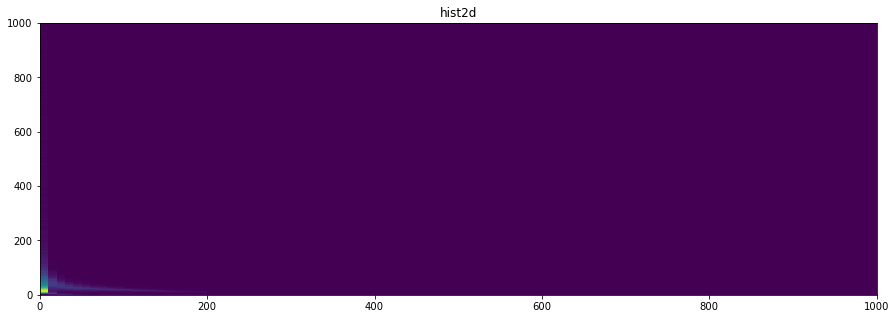

In [67]:
import ROOT as R
from rootpy.plotting import root2matplotlib as rplt
from rootpy.plotting import Hist2D, Canvas
from rootpy.interactive import wait
canvas = Canvas(width=700, height=500)
h2d = Hist2D(100,0,1000,1000,0,1000)
for i in range(len(dataNG['cs1'])):
    h2d.Fill(dataNG['cs1'].iloc[i], dataNG['cs2_bottom'].iloc[i]/dataNG['cs1'].iloc[i])
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
ax1.set_title('hist2d')
rplt.hist2d(h2d, axes=ax1)

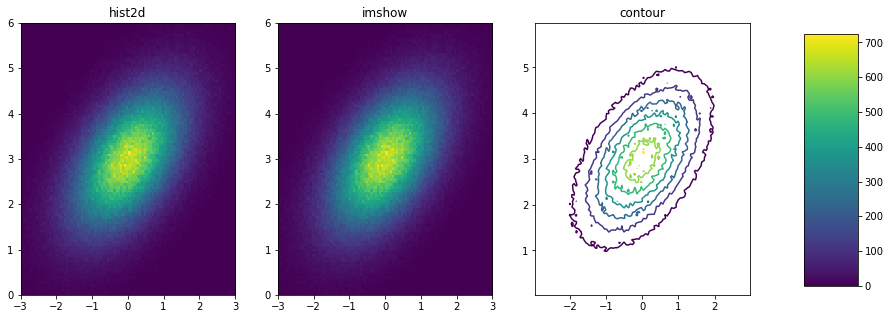

In [52]:
import ROOT
from matplotlib import pyplot as plt
from rootpy.plotting import root2matplotlib as rplt
from rootpy.plotting import Hist2D
import numpy as np

a = Hist2D(100, -3, 3, 100, 0, 6)
a.fill_array(np.random.multivariate_normal(
    mean=(0, 3),
    cov=[[1, .5], [.5, 1]],
    size=(1000000,)))

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

ax1.set_title('hist2d')
rplt.hist2d(a, axes=ax1)

ax2.set_title('imshow')
im = rplt.imshow(a, axes=ax2)

ax3.set_title('contour')
rplt.contour(a, axes=ax3)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

if not ROOT.gROOT.IsBatch():
    plt.show()

### Rn220

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


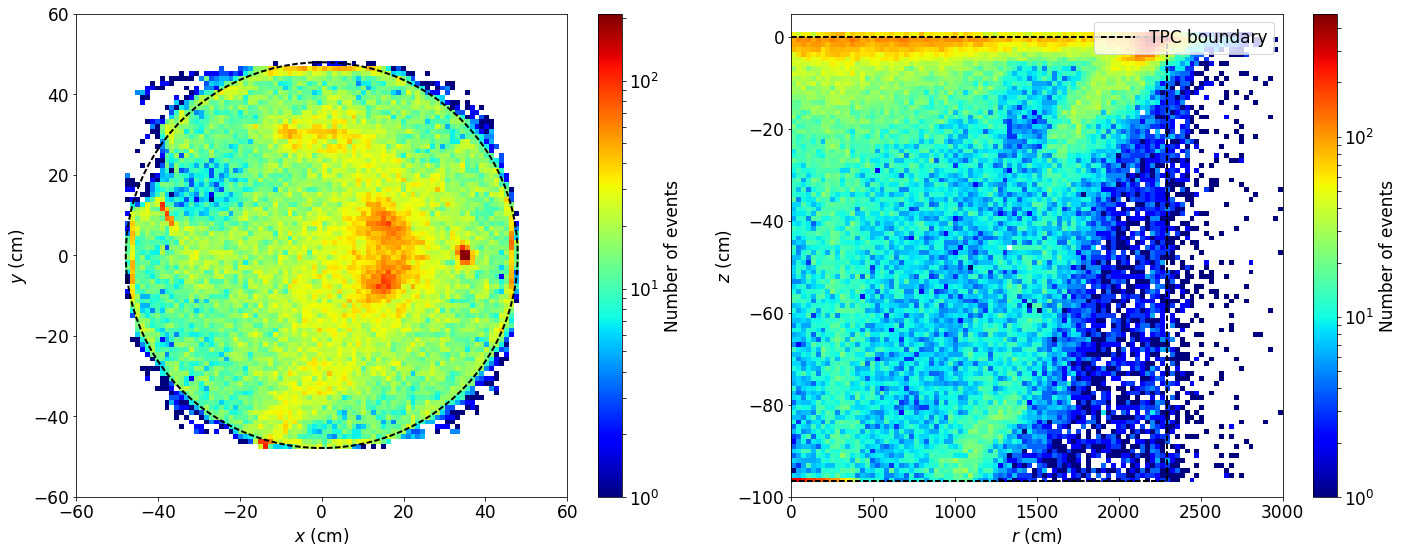

In [12]:
plt.figure(1, figsize=(20,8))
plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams.update({'font.size':17})

plt.subplot(121)
plt.hist2d(dataRn['x_observed_nn'], dataRn['y_observed_nn'], bins=(100,100), 
           range=((-60,60), (-60,60)), 
           cmap=plt.cm.jet, norm=matplotlib.colors.LogNorm(),
           cmin = 1,alpha = 1)
plt_circle(linewidth=2, color='black', linestyle='--')
plt.colorbar(label='Number of events')
plt.xlabel('$x~observed_{nn}$ (cm)')
plt.ylabel('$y~observed_{nn}$ (cm)')

plt.subplot(122)
plt.hist2d((dataRn['r_observed_nn']**2), dataRn['z_observed'], bins=(100,100), 
           range=((0,3000), (-100,5)), 
           cmap=plt.cm.jet, norm=matplotlib.colors.LogNorm(),
           cmin = 1,alpha = 1)
TPC_limit(1, linewidth=2, color='black', linestyle='--')
plt.colorbar(label='Number of events')
plt.xlabel('$r~observed_{nn}$ (cm)')
plt.ylabel('$z~observed$ (cm)')

plt.tight_layout()

### SR1 Cut

In [13]:
dfNG = dataNG
dfNG = sciencerun1.DAQVeto().process(dfNG)
dfNG = sciencerun1.FiducialCylinder1T().process(dfNG)
dfNG = sciencerun1.InteractionExists().process(dfNG)
dfNG = sciencerun1.InteractionPeaksBiggest().process(dfNG)
dfNG = sciencerun1.S1MaxPMT().process(dfNG) # Requires s1_largest_hit_area
dfNG = sciencerun1.S1PatternLikelihood().process(dfNG) # Requires s1_pattern_fit
dfNG = sciencerun1.S1SingleScatter().process(dfNG) # alt_s2_interaction_z
dfNG = sciencerun1.S2AreaFractionTop().process(dfNG)
dfNG = sciencerun1.S2SingleScatter().process(dfNG)
dfNG = sciencerun1.S2SingleScatterSimple().process(dfNG)
dfNG = sciencerun1.S2Threshold().process(dfNG)
dfNG = sciencerun1.S2Width().process(dfNG)

KeyError: 'previous_busy_on'

In [ ]:
dfRn = dataRn
dfRn = sciencerun0.DAQVeto().process(dfRn)
dfRn = sciencerun0.FiducialCylinder1T().process(dfRn)
dfRn = sciencerun0.InteractionExists().process(dfRn)
dfRn = sciencerun0.InteractionPeaksBiggest().process(dfRn)
dfRn = sciencerun0.S1MaxPMT().process(dfRn) # Requires s1_largest_hit_area
dfRn = sciencerun0.S1PatternLikelihood().process(dfRn) # Requires s1_pattern_fit
dfRn = sciencerun0.S1SingleScatter().process(dfRn) # alt_s2_interaction_z
dfRn = sciencerun0.S2AreaFractionTop().process(dfRn)
dfRn = sciencerun0.S2SingleScatter().process(dfRn)
dfRn = sciencerun0.S2SingleScatterSimple().process(dfRn)
dfRn = sciencerun0.S2Threshold().process(dfRn)
dfRn = sciencerun0.S2Width().process(dfRn)